In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import hdr_utils
from scipy.stats import gmean,cumfreq
import colour

0.98999995


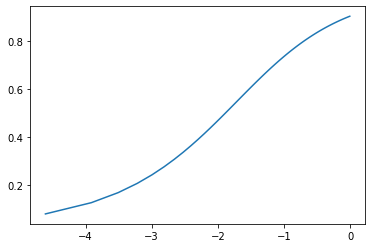

In [29]:
input_arr = np.arange(1,100).astype(np.float32)
exp = 0.01
exp_inp = exp*input_arr
out = hdr_utils.tonemap(input_arr,'aces',exp)
out = out**(1/2.2)
plt.plot(np.log(exp_inp),out)

In [14]:
h = 2160
w = 3840
alpha_A = 0.98
alpha_B = 0.98
alpha_a = 0.98

max_C = h*w
beta = 0.999
B_upper = beta*max_C
B_lower = (1-beta)*max_C
hdr_range = np.arange(0,1024)
input_file = '../../hdr_videos/cut_vids/acropolis_104.yuv'

In [15]:
y,u,v= hdr_utils.hdr_yuv_read(input_file,1,h,w)

# convert to RGB in BT2020
rgb_bt2020_pq = hdr_utils.yuv2rgb_bt2020(y,u,v)
rgb_bt2020_pq = np.clip(rgb_bt2020_pq.astype(np.float32),0,1024)/1024.0

# linearize
rgb_bt2020_linear = colour.models.eotf_PQ_BT2100(rgb_bt2020_pq)

# clip luminance to 100 nits
rgb_bt2020_linear_clipped = np.clip(rgb_bt2020_linear,0,300)

# convert to BT709
rgb_bt709_linear = colour.RGB_to_RGB(rgb_bt2020_linear,colour.models.RGB_COLOURSPACE_BT2020,colour.models.RGB_COLOURSPACE_BT709)

# find linear luminance
y_bt709_linear = 0.2126*rgb_bt2020_linear[:,:,0]+0.7152*rgb_bt2020_linear[:,:,1]+0.0722*rgb_bt2020_linear[:,:,2] 


858.897661941 0.0493321740031


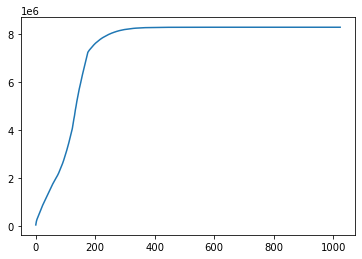

In [17]:
# find cumfreq
C,_,_,_ = cumfreq(y_bt709_linear.flatten(),1024,(0,1024))
print(np.max(y_bt709_linear),np.min(y_bt709_linear))
B_upper_index = (np.abs(C - B_upper)).argmin()
B_lower_index = (np.abs(C - B_lower)).argmin()

plt.plot(np.arange(0,1024),C)


In [19]:
# clamping vals
hdr_lower = hdr_range[B_lower_index]
hdr_upper = hdr_range[B_upper_index]
print(hdr_lower,hdr_upper)
y_bt709_linear_clipped = np.clip(y_bt709_linear,hdr_lower,hdr_upper)
print(np.min(y_bt709_linear_clipped),np.max(y_bt709_linear_clipped))
y_bt709_linear_clipped = y_bt709_linear_clipped-hdr_lower
#    y_bt709_linear_clipped = (y_bt709_linear_clipped-hdr_lower)*255/(hdr_upper-hdr_lower)
#    print(np.min(y_bt709_linear_clipped),np.max(y_bt709_linear_clipped))

# find current parameters for frame
L_av = gmean(y_bt709_linear_clipped,None)
Lmax = np.max(y_bt709_linear_clipped)
Lmin = np.min(y_bt709_linear_clipped)
A = Lmax-L_av
B = L_av-Lmin
a = 0.18*2**(2*(B-A)/(B+A))


# apply tonemap
lwhite_sq = hdr_upper**2 
image = a*y_bt709_linear_clipped/L_av
y_bt709_tonemapped_linear = image*(1+image/lwhite_sq)/(1+image)
print(np.min(y_bt709_tonemapped_linear),np.max(y_bt709_tonemapped_linear))


0 402
0.0493321740031 402.0
4.64858532088e-05 0.274744601518


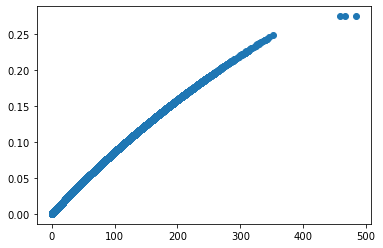

In [22]:
plt.plot(y_bt709_linear_clipped.flatten())